# Final Project
Time Series Forecasting of stock value using Recurrent Neural Networks (RNNs)

## Load Python Libraries

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import opendatasets as od
import time

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data Preparation

In [138]:
# Download the dataset
od.download("https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks", force=True)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


  0%|          | 0.00/43.3M [00:00<?, ?B/s]

100%|██████████| 43.3M/43.3M [00:07<00:00, 5.76MB/s]


In [139]:
# df_stocks = pd.read_csv('./sp-500-stocks/sp500_stocks.csv')
# df_companies = pd.read_csv('./sp-500-stocks/sp500_companies.csv')
df_index = pd.read_csv('./sp-500-stocks/sp500_index.csv')

In [140]:
df = df_index

In [141]:
import datetime
# change format from datatype to date 

def change_format(file):
    
    file['Date']=pd.to_datetime(file['Date'], format='%Y-%m-%d')
    
change_format(df)
# change_format(stocks)
df['Date']

0      2014-05-12
1      2014-05-13
2      2014-05-14
3      2014-05-15
4      2014-05-16
          ...    
2513   2024-05-06
2514   2024-05-07
2515   2024-05-08
2516   2024-05-09
2517   2024-05-10
Name: Date, Length: 2518, dtype: datetime64[ns]

In [142]:
df.set_index('Date', inplace=True)
df

,S&P500
Date,
2014-05-12,1896.65
2014-05-13,1897.45
2014-05-14,1888.53
2014-05-15,1870.85
2014-05-16,1877.86
...,...
2024-05-06,5180.74
2024-05-07,5187.70
2024-05-08,5187.67


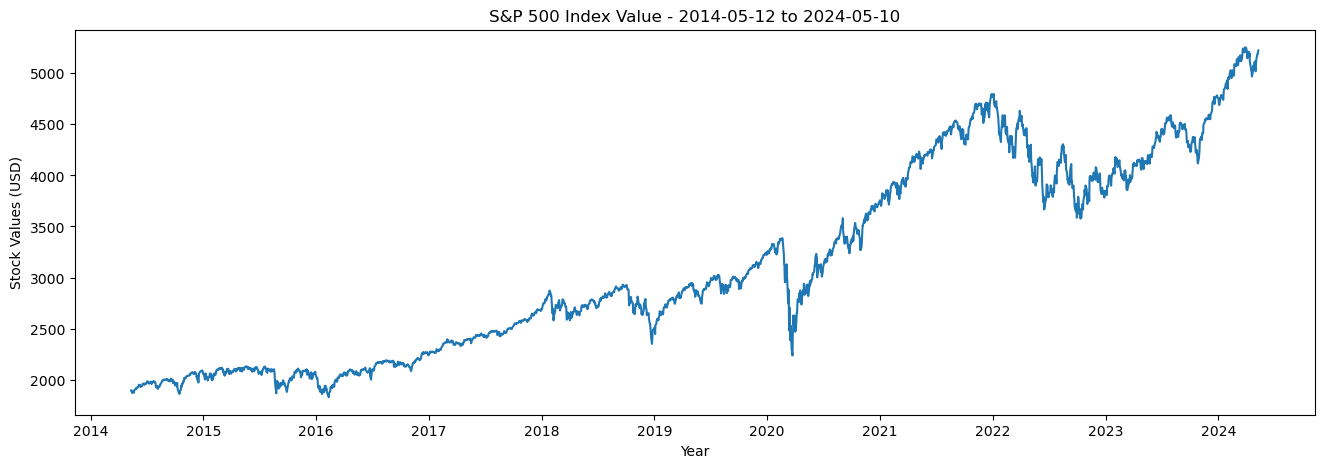

In [143]:
# plot the S&P 500 stock index
plt.figure(figsize=(16,5))
plt.title("S&P 500 Index Value - {} to {}".format(df.index.min().date(), df.index.max().date()))
plt.plot(df.index, df['S&P500'])
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')
plt.savefig("sp500.png")
plt.show()

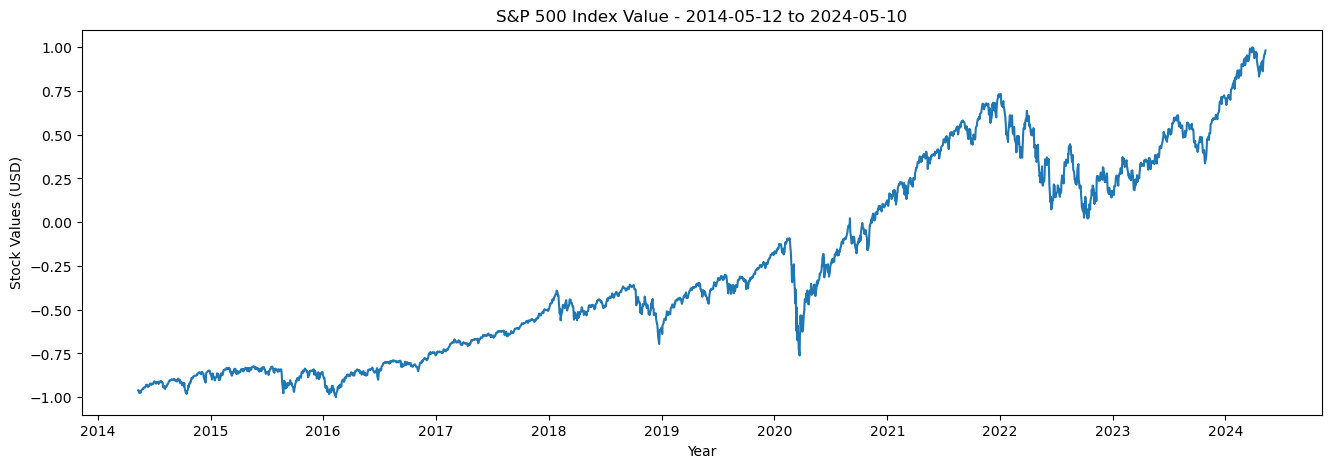

In [144]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['S&P500'] = scaler.fit_transform(df['S&P500'].values.reshape(-1, 1))

plt.figure(figsize=(16,5))
plt.title("S&P 500 Index Value - {} to {}".format(df.index.min().date(), df.index.max().date()))
plt.plot(df.index, df['S&P500'])
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')
plt.show()

### Create Train and Test Dataset

In [145]:
def load_data(df, lookback):
    data_raw = df.values
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)

    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)


    return [x_train, y_train, x_test, y_test]

lookback = 20

x_train, y_train, x_test, y_test = load_data(df, lookback)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1998, 19, 1), (1998, 1), (500, 19, 1), (500, 1))

In [146]:
# convert numpy sets to torch
# X_train = torch.tensor(X_train).float()
# Y_train = torch.tensor(Y_train).float()
# X_test = torch.tensor(X_test).float()
# Y_test = torch.tensor(Y_test).float()
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape, y_train_lstm.shape, y_train_gru.shape, x_test.shape, y_test_lstm.shape, y_test_gru.shape

(torch.Size([1998, 19, 1]),
 torch.Size([1998, 1]),
 torch.Size([1998, 1]),
 torch.Size([500, 19, 1]),
 torch.Size([500, 1]),
 torch.Size([500, 1]))

## LSTM

### Build the Model

#### Model Paramters

In [147]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

learning_rate = 0.01

num_epochs = 100

In [148]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim) # hidden states
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim) # cell states

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

model = LSTM(input_dim, hidden_dim, num_layers, output_dim)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

print(model)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Train the Model

In [149]:
hist_lstm = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train_lstm)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist_lstm[t] = loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

training_time_lstm = time.time()-start_time
print("Training time: {}".format(training_time_lstm))

Epoch  10 MSE:  0.09388794749975204


Epoch  20 MSE:  0.010624371469020844
Epoch  30 MSE:  0.008624914102256298
Epoch  40 MSE:  0.0030997677240520716
Epoch  50 MSE:  0.0014315397711470723
Epoch  60 MSE:  0.0011893403716385365
Epoch  70 MSE:  0.0009472619858570397
Epoch  80 MSE:  0.000883729662746191
Epoch  90 MSE:  0.0008552895160391927
Training time: 4.338820934295654


### Make Predictions

In [150]:
y_test_pred = model(x_test)

# invert predictions
yy_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
yy_train_lstm = scaler.inverse_transform(y_train_lstm.detach().numpy())
yy_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
yy_test_lstm = scaler.inverse_transform(y_test_lstm.detach().numpy())

### Results

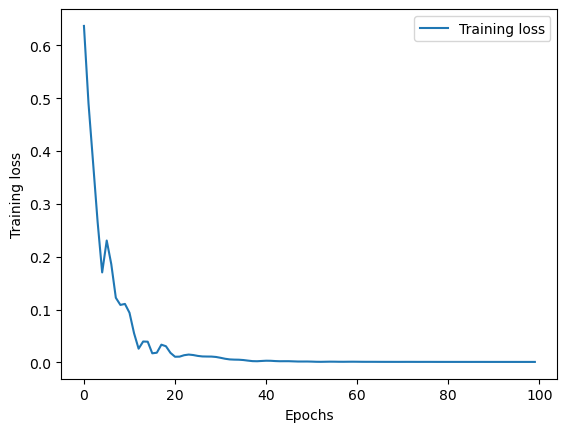

In [151]:
plt.plot(hist_lstm, label="Training loss")
plt.xlabel("Epochs"), plt.ylabel("Training loss")
plt.legend()
plt.show()

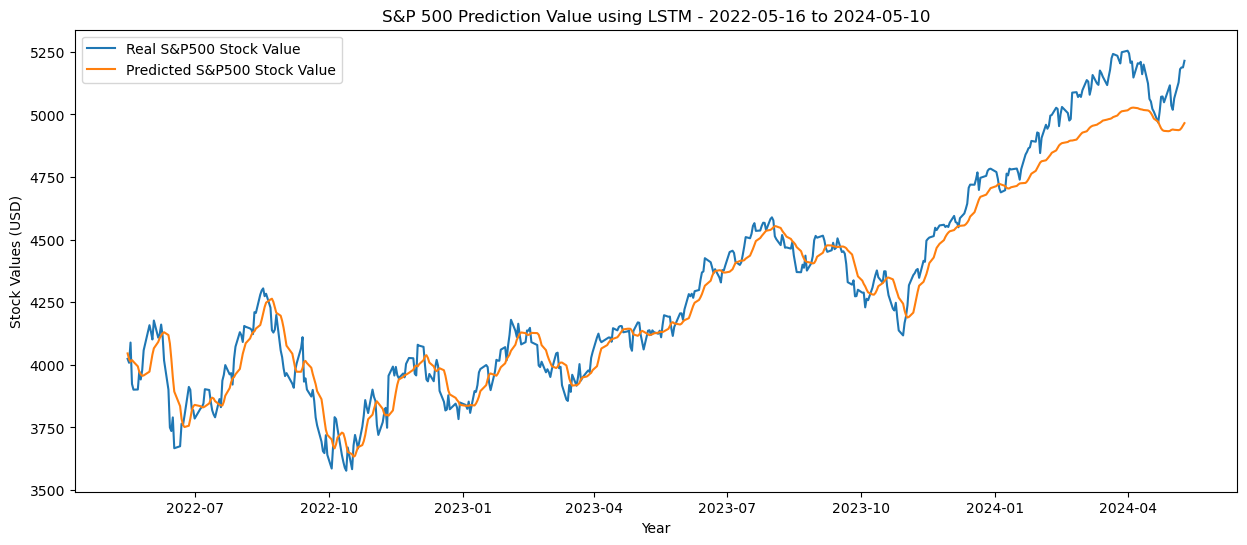

In [152]:
plt.figure(figsize=(15,6))

plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_lstm, label='Real S&P500 Stock Value')
plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_pred, label='Predicted S&P500 Stock Value')

plt.title("S&P 500 Prediction Value using LSTM - {} to {}"
          .format(df[len(df)-len(yy_test_lstm):].index.min().date(), df[len(df)-len(yy_test_lstm):].index.max().date()))
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')

plt.legend()
plt.savefig("stock_pred_lstm")

plt.show()

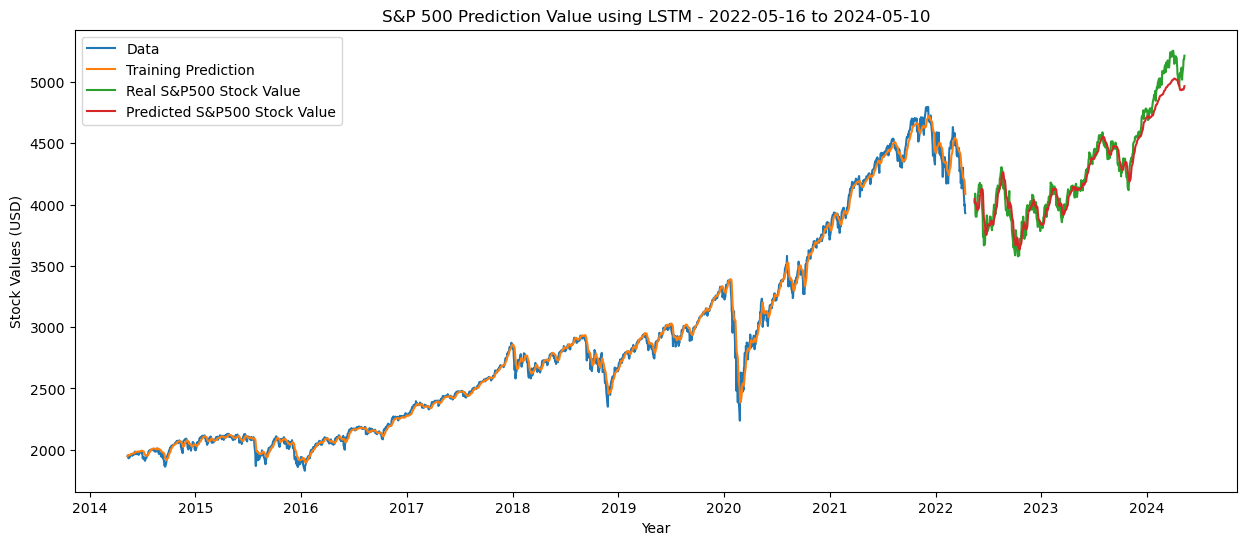

In [153]:
plt.figure(figsize=(15,6))

plt.plot(df[:len(yy_train_lstm)].index, yy_train_lstm, label='Data')
plt.plot(df[:len(yy_train_lstm)].index, yy_train_pred, label='Training Prediction')
plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_lstm, label='Real S&P500 Stock Value')
plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_pred, label='Predicted S&P500 Stock Value')

plt.title("S&P 500 Prediction Value using LSTM - {} to {}"
          .format(df[len(df)-len(yy_test_lstm):].index.min().date(), df[len(df)-len(yy_test_lstm):].index.max().date()))
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')

plt.legend()
plt.savefig("stock_pred_lstm_full")

plt.show()

## GRU

### Build the Model

In [154]:
# use same values for parameters as LSTM

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model_gru = GRU(input_dim, hidden_dim, num_layers, output_dim)
  
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr = learning_rate)

print(model_gru)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Train the Model

In [155]:
# same num of epochs

hist_gru = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model_gru(x_train)

    loss = loss_fn(y_train_pred, y_train_gru)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist_gru[t] = loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

training_time_gru = time.time()-start_time
print("Training time: {}".format(training_time_gru))

Epoch  10 MSE:  0.0017093083588406444
Epoch  20 MSE:  0.008546019904315472
Epoch  30 MSE:  0.0009863557061180472
Epoch  40 MSE:  0.000731602543964982
Epoch  50 MSE:  0.000776555621996522
Epoch  60 MSE:  0.0006733323680236936
Epoch  70 MSE:  0.0006074845441617072
Epoch  80 MSE:  0.0005729833501391113
Epoch  90 MSE:  0.0005505989538505673
Training time: 14.208264589309692


### Make Predictions

In [156]:
y_test_pred = model_gru(x_test)

# invert predictions
yy_train_pred_gru = scaler.inverse_transform(y_train_pred.detach().numpy())
yy_train_gru = scaler.inverse_transform(y_train_gru.detach().numpy())
yy_test_pred_gru = scaler.inverse_transform(y_test_pred.detach().numpy())
yy_test_gru = scaler.inverse_transform(y_test_gru.detach().numpy())

### Results

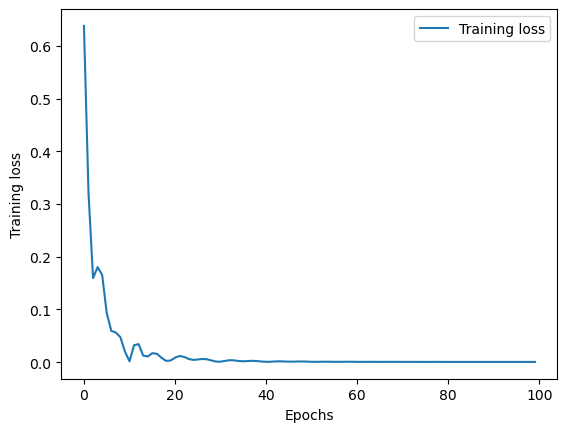

In [157]:
plt.plot(hist_gru, label="Training loss")
plt.xlabel("Epochs"), plt.ylabel("Training loss")
plt.legend()
plt.show()

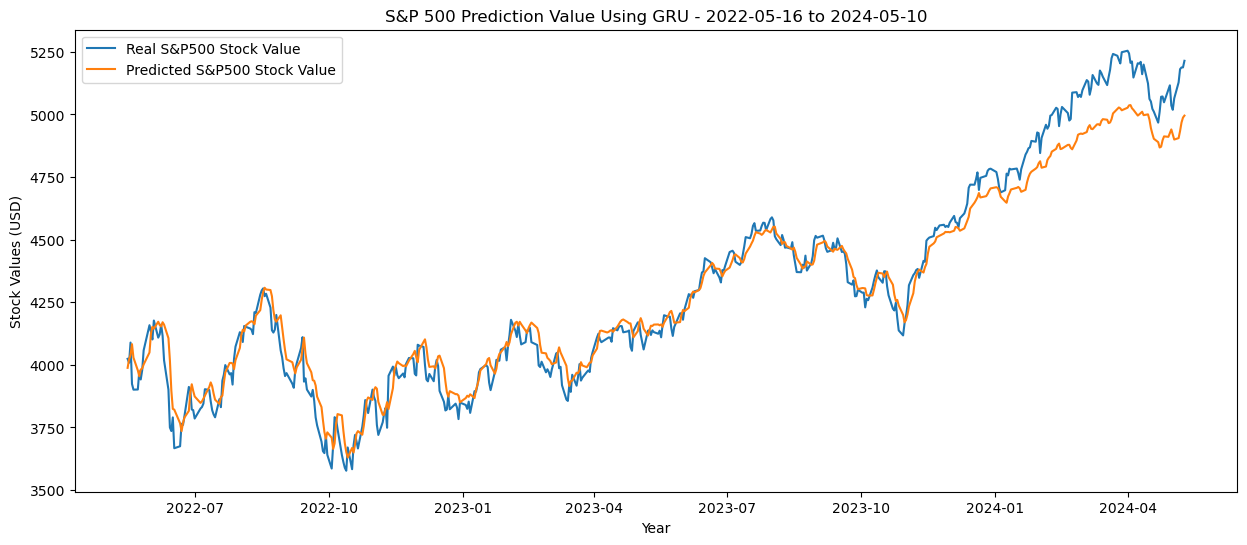

In [158]:
plt.figure(figsize=(15,6))

plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_gru, label='Real S&P500 Stock Value')
plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_pred_gru, label='Predicted S&P500 Stock Value')

plt.title("S&P 500 Prediction Value Using GRU - {} to {}"
          .format(df[len(df)-len(yy_test_gru):].index.min().date(), df[len(df)-len(yy_test_gru):].index.max().date()))
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')

plt.legend()
plt.savefig("stock_pred_gru")

plt.show()

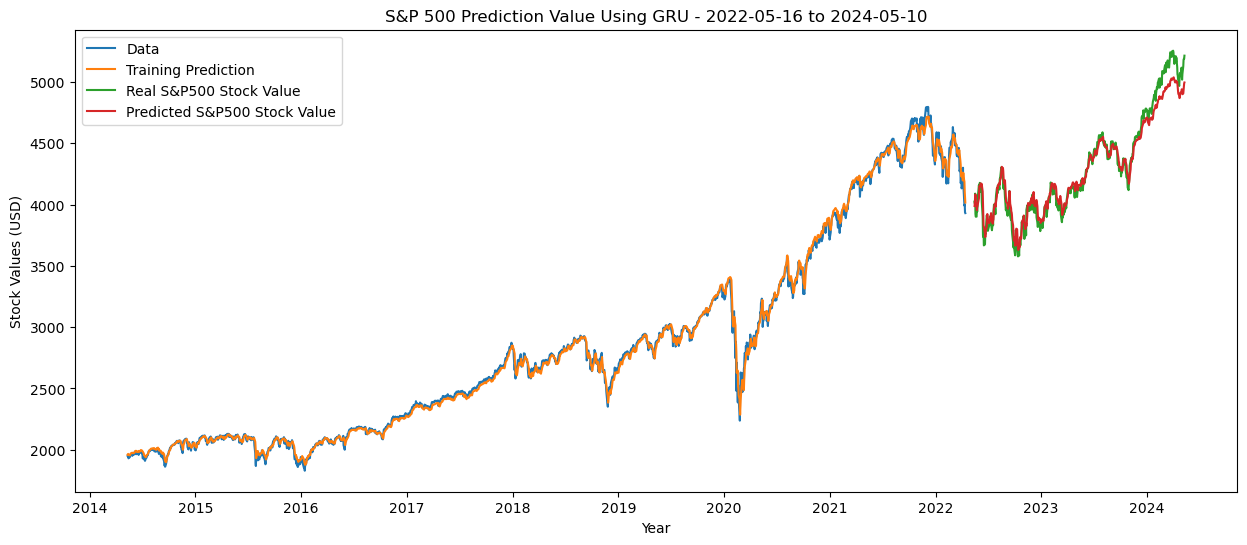

In [159]:
plt.figure(figsize=(15,6))

plt.plot(df[:len(yy_train_gru)].index, yy_train_gru, label='Data')
plt.plot(df[:len(yy_train_gru)].index, yy_train_pred_gru, label='Training Prediction')
plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_gru, label='Real S&P500 Stock Value')
plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_pred_gru, label='Predicted S&P500 Stock Value')

plt.title("S&P 500 Prediction Value Using GRU - {} to {}"
          .format(df[len(df)-len(yy_test_gru):].index.min().date(), df[len(df)-len(yy_test_gru):].index.max().date()))
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')

plt.legend()
plt.savefig("stock_pred_gru_full")

plt.show()

## Compare Results

In [160]:
print("LSTM Train Time: ", training_time_lstm)
print("GRU Train Time: ", training_time_gru)

LSTM Train Time:  4.338820934295654
GRU Train Time:  14.208264589309692


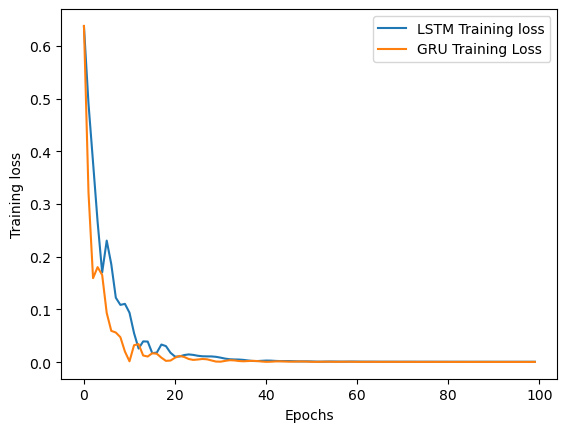

In [161]:
plt.plot(hist_lstm, label="LSTM Training loss")
plt.plot(hist_gru, label="GRU Training Loss")

plt.xlabel("Epochs"), plt.ylabel("Training loss")

plt.legend()
plt.show()

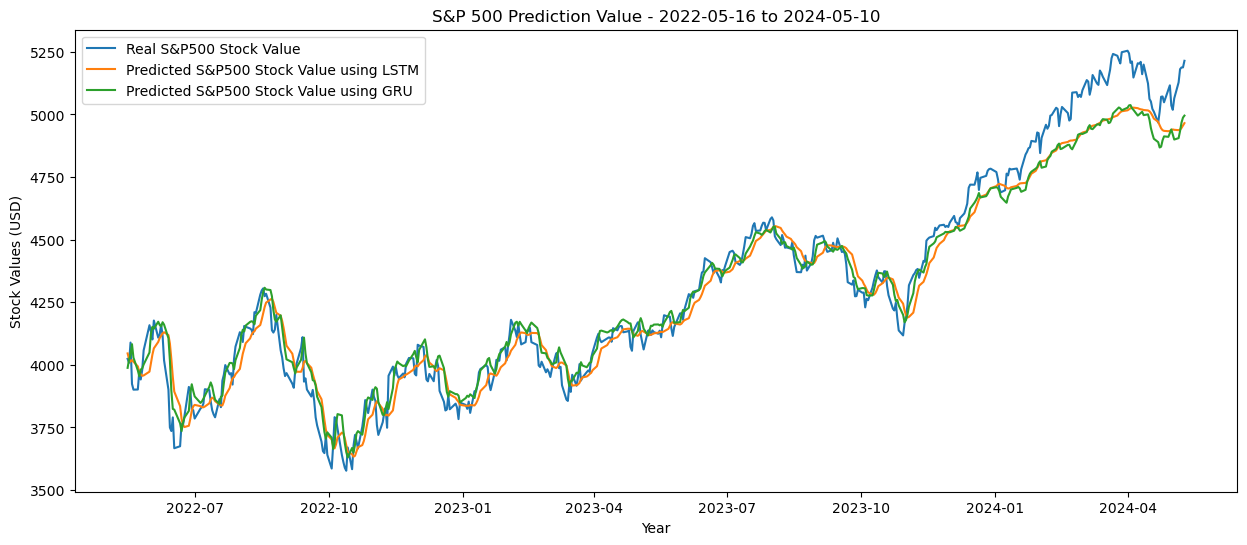

In [162]:
plt.figure(figsize=(15,6))

plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_lstm, label='Real S&P500 Stock Value')
plt.plot(df[len(df)-len(yy_test_lstm):].index, yy_test_pred, label='Predicted S&P500 Stock Value using LSTM')
# plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_gru, label='Real S&P500 Stock Value using GRU')
plt.plot(df[len(df)-len(yy_test_gru):].index, yy_test_pred_gru, label='Predicted S&P500 Stock Value using GRU')

plt.title("S&P 500 Prediction Value - {} to {}"
          .format(df[len(df)-len(yy_test_lstm):].index.min().date(), df[len(df)-len(yy_test_lstm):].index.max().date()))
plt.xlabel('Year'), plt.ylabel('Stock Values (USD)')

plt.legend()
plt.savefig("model_comparison")

plt.show()